<a href="https://colab.research.google.com/github/duytruong204/Project/blob/main/identify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo
!pip install extcolors

Requirement already up-to-date: torch in /usr/local/lib/python3.7/dist-packages (1.8.1+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.7/dist-packages (0.9.1+cu101)
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-vhe6y1fs
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-vhe6y1fs
  Created wheel for fvcore: filename=fvcore-0.1.5-cp37-none-any.whl size=64354 sha256=139fde1b520f369bcd3e574008c789aed83a76937e47ac8379241888f06f0bdb
  Stored in directory: /tmp/pip-ephem-wheel-cache-9u1bux39/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
Successfully built fvcore
fatal: destination path 'detectron2_repo' already exists and is not an empty directory.
Obtaining file:///content/detectron2_repo
  Found existing installation: detectron2 0.4.1
    Can't uninstall 'detectron2'. No files were found to uninstall.
  Running setup.py develop for detectron2


In [ ]:
import detectron2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
import os
from google.colab import drive
import time
from copy import copy
from math import sqrt
from extcolors import extract_from_image
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog
from google.colab.patches import cv2_imshow
import pandas as pd

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

#danh's function

In [ ]:
def Detect(file_name):
    #Load model
    cfg = get_cfg()
    cfg.merge_from_file("/content/drive/MyDrive/Model/config.yaml")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
    cfg.OUTPUT_DIR = "/content/drive/MyDrive/Model" 
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    predictor = DefaultPredictor(cfg)

    label = ["real image", "button", "block"]
    
    im = cv2.imread(file_name)
    outputs = predictor(im)

    pred_classes = outputs["instances"].pred_classes.cpu().tolist()

    pred_class_names = list(map(lambda x: label[x], pred_classes))
    pred_boxes = outputs["instances"].pred_boxes.tensor.tolist()
    
    return pred_class_names, pred_boxes


def rgb_to_hsl(r, g, b):
    r, g, b = [x / 255.0 for x in (r, g, b)]
    maxc = max(r, g, b)
    minc = min(r, g, b)
    l = (maxc + minc) / 2.0

    if maxc == minc:
        h = s = 0
    else:
        delta = maxc - minc
        s = delta / (2 - maxc - minc) if l > 0.5 else delta / (maxc + minc)
        if maxc == r:
            if g < b:
                h = (g - b) / delta + 6
            else:
                h = (g - b) / delta
        elif maxc == g:
            h = (b - r) / delta + 2
        else:
            h = (r - g) / delta + 4
    h = round(h * 60)
    s = round(s * 100)
    l = round(l * 100)
    return h, s, l


def rgb_to_hex(rgb):
    return ('#%02x%02x%02x' % rgb).upper()


def is_neutral(s, l):
    if s <= (80 * l * l - 8000 * l + 52080) / 1849 + 100:
        return True
    else:
        return False  


def group_similar_hue(list_colors, S_dmn, L_dmn, m):
  list_groups_of_colors = []

  while list_colors:
    remain_colors = copy(list_colors)
    grouped_colors = []
    peak = list_colors[0]
    for x in remain_colors:
        if peak[1][0] + m >= x[1][0] >= peak[1][0] - m:
            grouped_colors.append(x)
    list_colors = list(set(list_colors) - set(grouped_colors))
    list_groups_of_colors.append(grouped_colors)

  short_list = []
  for group_color in list_groups_of_colors:
    percent_coverage = 0
    distance_SL = []
    for color in group_color:
        S_color, L_color = color[1][1:]
        percent_coverage += color[3]
        distance_SL.append((S_dmn - S_color) ** 2 + (L_dmn - L_color) ** 2)
    index = distance_SL.index(min(distance_SL))
    short_list.append((group_color[index][0], group_color[index][1], percent_coverage))
  return short_list


def separate_colors(all_colors, pixels):
  neutrals = []
  list_colorful = []
  for extracted_color in all_colors:
      r, g, b = [x for x in extracted_color[0]]
      percent_cover = extracted_color[1] / pixels
      h, s, l = rgb_to_hsl(r, g, b)
      if is_neutral(s, l):
          neutrals.append((rgb_to_hex(extracted_color[0]), (h, s, l), extracted_color[0], percent_cover))
      else:
          list_colorful.append((rgb_to_hex(extracted_color[0]), (h, s, l), extracted_color[0], percent_cover))
  return neutrals, list_colorful

#Danh's code

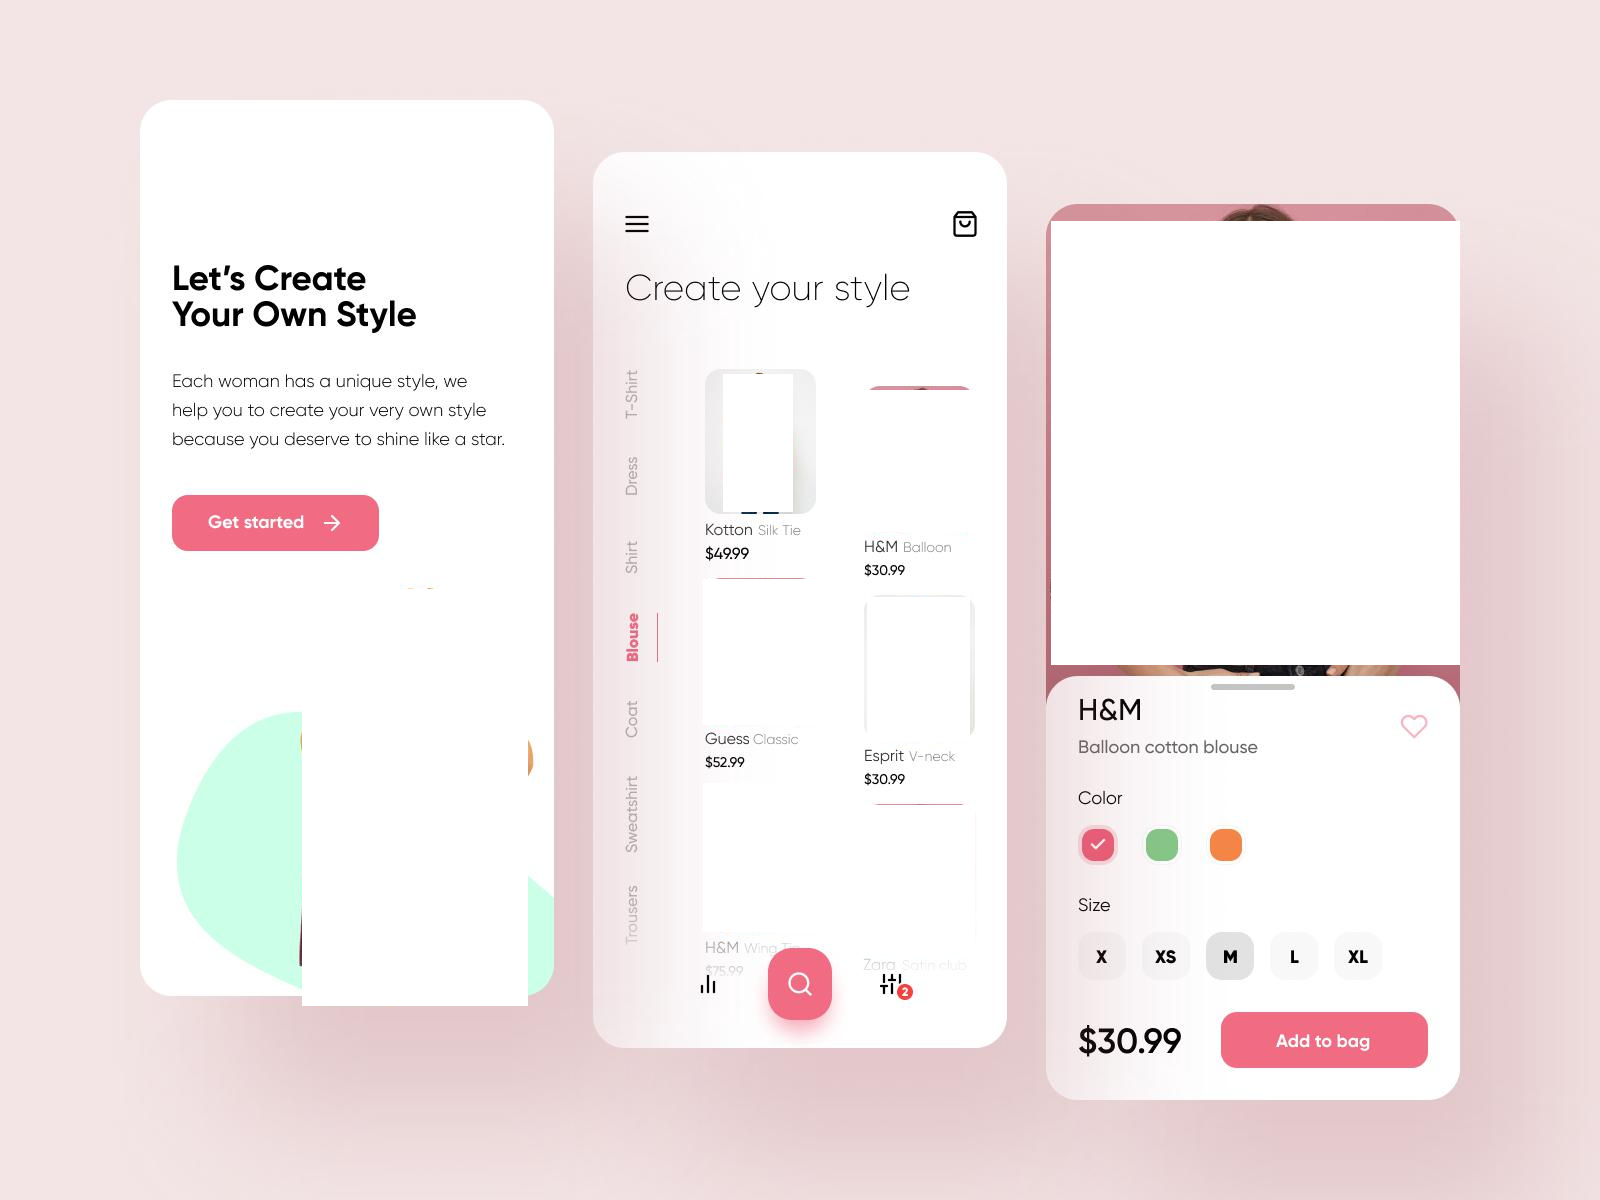

short_list_colors: [('#CBFFE8', (153, 100, 90), 0.013715104166666645), ('#D7FFD9', (123, 100, 92), 0.000358854166666666), ('#FFCBD7', (346, 100, 90), 0.010710416666666491), ('#FFCDD3', (353, 100, 90), 0.008403645833333199), ('#CBFFDA', (137, 100, 90), 3.4895833333333325e-05), ('#FFD1CE', (4, 100, 90), 0.00013072916666666612), ('#FFD6CA', (14, 100, 90), 0.0004286458333333311), ('#FFE0CB', (24, 100, 90), 0.0007822916666666795), ('#FFCDCE', (359, 100, 90), 0.00010052083333333297), ('#FFE8CC', (33, 100, 90), 5.572916666666655e-05), ('#FFCECD', (1, 100, 90), 6.510416666666649e-05), ('#CAFFEF', (162, 100, 90), 8.958333333333327e-05), ('#C6FFF2', (166, 100, 89), 5.729166666666668e-06), ('#DDFFD6', (110, 100, 92), 3.6458333333333333e-06), ('#D7FFDB', (126, 100, 92), 9.895833333333336e-06), ('#FFD2E6', (333, 100, 91), 6.770833333333335e-06), ('#CCFFD7', (133, 100, 90), 1.0416666666666667e-06), ('#FFF9D8', (51, 100, 92), 4.166666666666668e-06), ('#FFE5CE', (28, 100, 90), 7.812500000000002e-06), 

In [ ]:
t = time.time()

image_path = "/content/drive/MyDrive/Colab Notebooks/New folder/ecommere2.jpg"
list_name, list_box = Detect(image_path)
image = cv2.imread(image_path)
for index, box in enumerate(list_box):
  x_1, y_1, x_2, y_2 = [int(b) for b in box]
  if list_name[index] == 'real image':
    image = cv2.rectangle(image, (x_1, y_1), (x_2, y_2), (255, 255, 255), -1)
cv2_imshow(image)
img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
img = Image.fromarray(img)

# extract all colors in the image
all_colors, pixels = extract_from_image(img, tolerance=0)
neutrals, list_colorful = separate_colors(all_colors, pixels)

# group colors which have similar hue value
m = 5  # group colors in range +-m
S_dmn, L_dmn = neutrals[0][1][1:]  # S, L of dominant color (neutral colors)
short_list_neutral = group_similar_hue(neutrals, S_dmn, L_dmn, m)
try:
  S_dmn, L_dmn = list_colorful[0][1][1:]  # S, L of dominant color (exclude neutral colors)
except:
  pass
short_list_colors = group_similar_hue(list_colorful, S_dmn, L_dmn, m)

###############################################################################
# colors & size of buttons
# colors & size of buttons
short_list_buttons = []
for index, box in enumerate(list_box):
  x_1, y_1, x_2, y_2 = [int(b) for b in box]
  w, h = x_2 - x_1, y_2 - y_1
  if list_name[index] == 'button':
    button = img.crop((x_1, y_1, x_2, y_2))
    colors_button, pixels_button = extract_from_image(button, tolerance=0)
    neutrals_1, list_colorful_1 = separate_colors(colors_button, pixels_button)
    if neutrals_1:
      if list_colorful_1 and list_colorful_1[0][-1] > neutrals_1[0][-1]:
        S_dmn, L_dmn = list_colorful_1[0][1][1:]
        button_infor = group_similar_hue(list_colorful_1, S_dmn, L_dmn, m)
        button_infor.append((w, h))
        button_infor.append(w*h)
        short_list_buttons.append(button_infor)
    else:
        S_dmn, L_dmn = list_colorful_1[0][1][1:]
        button_infor = group_similar_hue(list_colorful_1, S_dmn, L_dmn, m)
        button_infor.append((w, h))
        button_infor.append(w*h)
        short_list_buttons.append(button_infor)
###############################################################################
# Output for team 2:
elements = []
for x in short_list_buttons:
  elements.append([0, x[-2][0], x[-2][1], [c for c in x[:-2]]])
# # shortl_list: HEX, HSL, % Coverage
print(f'short_list_colors: {short_list_colors}')
print(f'short_list_neutral: {short_list_neutral}')
# # elements: Type (0: button), Width, Height, [(HEX, HSL, Coverage),...] 
print(f'elements: {elements}')

print(f'Runtime: {time.time() - t}')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#function of team2

In [ ]:
def main_take_color(elements,colors,data_list):
  list_primary = []
  list_secondary = []
  ##take primary color
  new_element = pd.DataFrame(elements, columns=['Type', 'Width ', 'Height','Color of Button',"Radius"])
  new_element['Area'] = (new_element.iloc[:, [1]].values * new_element.iloc[:, [2]].values )
  just_button = new_element[['Type', 'Color of Button','Area']].loc[new_element['Type'] == 0]#get button
  just_biggest_button = just_button.loc[just_button['Area'] == just_button['Area'].max()]#getmax
  list_color_of_button = pd.DataFrame(to_list(just_biggest_button), columns=['Color', 'coverage'])
  list_color_of_button = list_color_of_button.loc[list_color_of_button['coverage'] == list_color_of_button['coverage'].max()]
  color_coverage = pd.DataFrame(colors,columns=['Color',"coverage"])
  color_coverage = color_coverage.loc[color_coverage['coverage'] == color_coverage['coverage'].max()]
  if list_color_of_button.shape[0] == 1:
    primary = list_color_of_button.iloc[[0],[0]].values[0][0] 
    list_primary.append(list_color_of_button.iloc[[0],[0]].values[0][0])
  elif color_coverage.shape[0] == 1:
    primary = color_coverage.iloc[[0],[0]].values[0][0]
    list_primary.append(color_coverage.iloc[[0],[0]].values[0][0])
  else:
    primary = None
    list_primary = [[]]
  ##take secondary
  #list of button
  list_color_of_button = pd.DataFrame(to_list(just_button), columns=['Color', 'coverage'])
  list_color_of_button = list_color_of_button.loc[list_color_of_button['Color'] != primary]#exclude primary
  list_color_of_button = list_color_of_button.sort_values(by=['coverage'],ascending=False)#sort
  #color
  color_coverage = pd.DataFrame(colors,columns=['Color',"coverage"])
  color = color_coverage.loc[color_coverage['Color'] != primary]#exclude primary
  color = color.sort_values(by=['coverage'],ascending=False)#sort
  color_list = delete_element(coverage_to_list(color),coverage_to_list(list_color_of_button))
  color_logo = None
  rest_of_color = rest_element(color_list,coverage_to_list(color))
  list_secondary.append(make_second(soft_coverage(color_list),soft_coverage(color_logo),soft_coverage(rest_of_color)))
  ##get palette
  data_list.append(tuple(list_primary+[list_secondary[0][0:5]]+palette_type(list_primary,list_secondary)))

In [ ]:
def rest_element(list1,list2):
  a = []
  b = []
  if list2 is None:
    return None
  elif list1 is None:
    return list2 
  else:
    for i in range(len(list1)):
      b.append(list1[i][0])
    for i in range(len(list2)):
      if not list2[i][0] in b:
        a.append(list2[i]);
  if len(a) == 0:
    return None
  return a 

In [ ]:
def palette_type(list_primary,list_secondary):
  if len(list_primary) == 1 and len(list_secondary[0][0:5]) == 0:
    return ['Monotune']
  elif len(list_primary) == 1 and len(list_secondary[0][0:5]) == 1:
    return ['Duetune']
  elif len(list_primary) == 1 and len(list_secondary[0][0:5]) >= 2:
    return ['Colorful']

In [ ]:
def coverage_to_list(mydataframe):
  list_color = []
  for i in range(mydataframe.shape[0]):
    list_color.append([mydataframe.iloc[:, [0,1]].values[i][0],mydataframe.iloc[:, [0,1]].values[i][1]])
  return list_color

In [ ]:
def delete_element(list1,list2):
  a = []
  b = []
  if list2 is None:
    return list1
  else:
    for i in range(len(list2)):
      b.append(list2[i][0])
    for i in range(len(list1)):
      if (list1[i][0] in b):
        a.append(list1[i]);
    if len(a) == 0:
      return None
    return a

In [ ]:
def soft_coverage(list):
  if list is None:
    return None
  else:
    data_list = pd.DataFrame(list, columns=['Color','coverage'])
    data_list = data_list.sort_values(by=['coverage'],ascending=False)#sort
    return coverage_to_list(data_list)

In [ ]:
def make_second(list1,list2,list3):
  sum = []
  a = []
  sum = turn_none(list1) + turn_none(list2) + turn_none(list3)
  for i in range(len(sum)):
    a.append(sum[i][0])
  return a

In [ ]:
def turn_none(element):
  if element is None:
    return []
  else:
    return element

In [ ]:
def to_list(mydataframe):
  color_of_button = mydataframe.iloc[:, [1]].values 
  list_of_button = []
  list_color = []
  for i in range(color_of_button.shape[0]): 
    list_of_button.append(color_of_button[i][0])
  for i in range(len(list_of_button)):
    for j in range(len(list_of_button[i])):
      list_color.append(list_of_button[i][j])
  return list_color

In [ ]:
def extract(image_path):
  list_name, list_box = Detect(image_path)
  image = cv2.imread(image_path)
  for index, box in enumerate(list_box):
    x_1, y_1, x_2, y_2 = [int(b) for b in box]
    if list_name[index] == 'real image':
      image = cv2.rectangle(image, (x_1, y_1), (x_2, y_2), (255, 255, 255), -1)
  #cv2_imshow(image)
  img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  img = Image.fromarray(img)

  # extract all colors in the image
  all_colors, pixels = extract_from_image(img, tolerance=0)
  neutrals, list_colorful = separate_colors(all_colors, pixels)

  # group colors which have similar hue value
  m = 5  # group colors in range +-m
  S_dmn, L_dmn = neutrals[0][1][1:]  # S, L of dominant color (neutral colors)
  short_list_neutral = group_similar_hue(neutrals, S_dmn, L_dmn, m)
  try:
    S_dmn, L_dmn = list_colorful[0][1][1:]  # S, L of dominant color (exclude neutral colors)
  except:
    pass
  short_list_colors = group_similar_hue(list_colorful, S_dmn, L_dmn, m)

  ###############################################################################
  # colors & size of buttons
  short_list_buttons = []
  for index, box in enumerate(list_box):
    x_1, y_1, x_2, y_2 = [int(b) for b in box]
    w, h = x_2 - x_1, y_2 - y_1
    if list_name[index] == 'button':
      button = img.crop((x_1, y_1, x_2, y_2))
      colors_button, pixels_button = extract_from_image(button, tolerance=0)
      neutrals_1, list_colorful_1 = separate_colors(colors_button, pixels_button)
      if neutrals_1:
        if list_colorful_1 and list_colorful_1[0][-1] > neutrals_1[0][-1]:
          S_dmn, L_dmn = list_colorful_1[0][1][1:]
          button_infor = group_similar_hue(list_colorful_1, S_dmn, L_dmn, m)
          button_infor.append((w, h))
          button_infor.append(w*h)
          short_list_buttons.append(button_infor)
      else:
          S_dmn, L_dmn = list_colorful_1[0][1][1:]
          button_infor = group_similar_hue(list_colorful_1, S_dmn, L_dmn, m)
          button_infor.append((w, h))
          button_infor.append(w*h)
          short_list_buttons.append(button_infor)
  ###############################################################################
  # Output for team 2:
  elements = []
  for x in short_list_buttons:
    elements.append([0, x[-2][0], x[-2][1], [c for c in x[:-2]]])
  # # shortl_list: HEX, HSL, % Coverage
  #print(f'short_list_colors: {short_list_colors}')
  #print(f'short_list_neutral: {short_list_neutral}')
  # # elements: Type (0: button), Width, Height, [(HEX, HSL, Coverage),...] 
  #print(f'elements: {elements}')
  return elements,short_list_colors

In [ ]:
def elements(path):
  the_data = pd.DataFrame(extract(path)[0],columns = ['Type','Height','Width','(HEX, HSL, Coverage)'])
  d = []
  x = the_data.iloc[:,[3]].values
  for i in range(the_data.shape[0]):
    a = []
    x[i][0] = pd.DataFrame(x[i][0],columns = ['hex','hsl','coverage'])[['hsl','coverage']].iloc[:,[0,1]]
    for j in range(x[i][0].shape[0]):
      b = x[i][0].iloc[:,[0]].values[j][0]
      c = x[i][0].iloc[:,[1]].values[j][0]
      a.append((b,c))
    d.append(a)
  the_data['Color'] = d
  the_data['radius'] = ['None']*the_data.shape[0]
  data = the_data[['Type','Height','Width','Color','radius']]
  m = data.values.tolist()
  k = []
  for i in m:
    k.append(tuple(i))
  return k
def colors(path):
  the_data = pd.DataFrame(extract(path)[1],columns = ['hex','(hsl)','coverage'])
  a = []
  for j in range(the_data.shape[0]):
    b = the_data.iloc[:,[1]].values[j][0]
    c = the_data.iloc[:,[2]].values[j][0]
    a.append((b,c))
  return a

#Main of team2

In [ ]:
import os

In [ ]:
data_list = []
folder = '/content/drive/MyDrive/Colab Notebooks/3.Smart_design_assistant/Data/healthcare'
for filename in os.listdir(folder):
  img = (os.path.join(folder,filename))
  path = img
  try:
    main_take_color(elements(path),colors(path),data_list)
  except:
    continue
main_data = pd.DataFrame(data_list,columns=['Primary','Secondary','Palette type'])
main_data.head()
compression_opts = dict(method='zip',
                        archive_name='healthcare.csv')
main_data.to_csv('out.zip', index=False,
          compression=compression_opts)